In [1]:
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
import cv2
import numpy as np

annFile = "/home/josmar/proyectos/codes/datasets/ucb_gait_combined/annotations/combined_val_ucb_gait.json"
# initialize COCO api for instance annotations
coco=COCO(annFile)

loading annotations into memory...
Done (t=1.76s)
creating index...
index created!


In [2]:
category = "person"
catIds = coco.getCatIds(catNms=[category])
imgIds = coco.getImgIds(catIds=catIds )
print(len(imgIds))

2175


In [3]:
def show_bbox (image, bbox_list):
    show_img = np.copy(image)
    for bbox in bbox_list:
        [x1,y1,x2,y2] = bbox 
        cv2.rectangle(show_img, (int(x1), int(y1)), (int(x2), int(y2)), (255,0,0), 5)
    plt.imshow(show_img)
    plt.show()

In [4]:
def show_polygon(image, polygons):
    show_image = np.copy(image)
    cv2.polylines(show_image, polygons, True, (0,255,0), thickness=3)
    plt.imshow(show_image)
    plt.show()
# np.int32([polygons_transformed[0]])

In [5]:
def get_boxes_and_polygons(anns):
    bboxes = []
    polys = []
    for ann in anns:
        bbox = [ann["bbox"][0], ann["bbox"][1], ann["bbox"][0]+ann["bbox"][2], ann["bbox"][1]+ann["bbox"][3]]
        bboxes.append(bbox)

        poly_img = ann["segmentation"]
        for poly in poly_img:
            poly = np.reshape(poly, (-1,2))
            polys.append(np.int32(poly)) 
    return bboxes, polys 

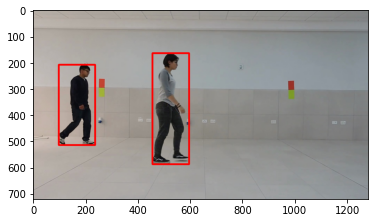

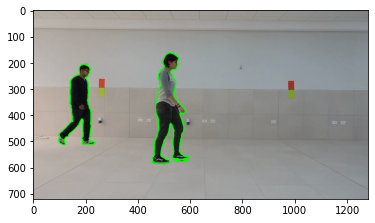

In [99]:
dir_path = "/home/josmar/proyectos/codes/01_annotation_tools/test_data/images"
coco_img = coco.loadImgs(imgIds[0])[0]

img_name = coco_img["file_name"]
img_dir = os.path.join(dir_path, img_name)

annIds = coco.getAnnIds(imgIds=coco_img['id'], catIds=catIds, iscrowd=None)
coco_anns = coco.loadAnns(annIds)

image = cv2.imread(img_dir)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

bboxes, polygons = get_boxes_and_polygons(coco_anns)
show_bbox(image, bboxes)
show_polygon(image, polygons)


In [7]:
from detectron2.data import transforms as T
# Define a sequence of augmentations:
augs = T.AugmentationList([
    T.RandomBrightness(0.9, 1.1),
    T.RandomFlip(prob=0.5),
    T.RandomCrop("absolute", (640, 640))
])  # type: T.Augmentation

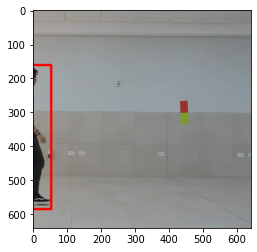

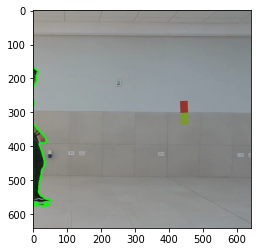

In [100]:
# Define the augmentation input ("image" required, others optional):
input = T.AugInput(image, boxes=bboxes)
# Apply the augmentation:
transform = augs(input)  # type: T.Transform
image_transformed = np.array(input.image)  # new image
boxes_transformed = input.boxes  # new semantic segmentation
polygons_copy = np.copy(polygons)
polygons_transformed = transform.apply_polygons(polygons_copy)
new_poly = [np.int32(p) for p in polygons_transformed]
show_bbox(image_transformed, boxes_transformed)
show_polygon(image_transformed, new_poly)


## Albumentations

### Functions to find masks and bboxes

In [1]:
def show_bbox_coco(image, bbox_list):
    show_img = np.copy(image)
    for bbox in bbox_list:
        [x,y,w,h] = bbox 
        cv2.rectangle(show_img, (int(x), int(y)), (int(x+w), int(y+h)), (255,0,0), 5)
    plt.imshow(show_img)
    plt.show()

In [2]:
def show_polygon(image, polygons):
    show_image = np.copy(image)
    cv2.polylines(show_image, polygons, True, (0,255,0), thickness=3)
    plt.imshow(show_image)
    plt.show()
# np.int32([polygons_transformed[0]])

In [3]:
def get_iou(boxA, boxB):
	# determine the (x, y)-coordinates of the intersection rectangle
	xA = max(boxA[0], boxB[0])
	yA = max(boxA[1], boxB[1])
	xB = min(boxA[2], boxB[2])
	yB = min(boxA[3], boxB[3])
	# compute the area of intersection rectangle
	interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
	# compute the area of both the prediction and ground-truth
	# rectangles
	boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
	boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
	# compute the intersection over union by taking the intersection
	# area and dividing it by the sum of prediction + ground-truth
	# areas - the interesection area
	iou = interArea / float(boxAArea + boxBArea - interArea)
	# return the intersection over union value
	return iou

In [4]:
def bbox_to_coord(bbox):
    new_bbox = bbox[:]
    new_bbox[2] = new_bbox[0] + new_bbox[2]
    new_bbox[3] = new_bbox[1] + new_bbox[3]
    return new_bbox

### Functions to create polygon annotations

In [5]:
def mask_by_color(img, color):    
    mask = img == color
    return np.all(mask,axis = -1)

In [6]:
def create_submasks(img,colors):
    submasks = []
    black = np.array([0,0,0])
    colors = colors[~(colors==black).all(axis=1),:]
    for color in colors:
        submasks.append(mask_by_color(img,color))
    return submasks

In [7]:
def unique_row_view(data):
    b = np.ascontiguousarray(data).view(
        np.dtype((np.void, data.dtype.itemsize * data.shape[1]))
    )
    u = np.unique(b).view(data.dtype).reshape(-1, data.shape[1])
    return u

In [8]:
def close_contour(contour):
    if not np.array_equal(contour[0], contour[-1]):
        contour = np.vstack((contour, contour[0]))
    return contour

In [9]:
import json
import numpy as np
from pycocotools import mask
from skimage import measure
import random

def mask_to_annotation(in_mask, img_id, img_cat, ann_id, is_crowd):
    ground_truth_binary_mask = in_mask
    fortran_ground_truth_binary_mask = np.asfortranarray(ground_truth_binary_mask)
    encoded_ground_truth = mask.encode(fortran_ground_truth_binary_mask)
    ground_truth_area = mask.area(encoded_ground_truth)
    ground_truth_bounding_box = mask.toBbox(encoded_ground_truth)

    padded_binary_mask = np.pad(ground_truth_binary_mask, pad_width=1, mode='constant', constant_values=0)
    contours = measure.find_contours(padded_binary_mask, 0.5)
    contours = np.subtract(contours, 1)

    polygons =[]
    for contour in contours:
        contour = close_contour(contour)
        contour = measure.approximate_polygon(contour, 0)   #tolerance = 0
        if len(contour) < 3:
            continue

        contour = np.flip(contour, axis=1)
        segmentation = contour.ravel().tolist()
        segmentation = [0 if i < 0 else i for i in segmentation]
        polygons.append(segmentation)
    
    annotation = {
            "segmentation": polygons,
            "area": ground_truth_area.tolist(),
            "iscrowd": is_crowd,
            "image_id": img_id,
            "bbox": ground_truth_bounding_box.tolist(),
            "category_id": img_cat,
            "id": ann_id
        }
    
    return annotation

In [14]:
def images_to_annotations(coco, imgIds, transform, dir_path, out_dir=None): #(dir_path, img_names):
    images=[]
    annotations = []
    
    img_license = 0
    img_id = 0
    ann_id = 0 
    is_crowd = 0
    img_cat = 1
           
    for imgId in imgIds:
        n_mask = 0
        while(n_mask == 0):
            image, class_labels, bboxes, masks = get_img_info(coco = coco, imgId = imgId, dir_path=dir_path)
            t_image, t_labels, t_bboxes, t_masks = transform_image(transform, image, class_labels, bboxes, masks)
            n_mask = len(t_bboxes)
        
        #CREATE NEW NAME
        coco_img = coco.loadImgs(imgId)[0]
        img_name = "crop_{}".format(coco_img["file_name"])
        
        img_size = t_image.shape

        # Saving the image
        save_img = cv2.cvtColor(t_image, cv2.COLOR_RGB2BGR)
        if out_dir is not None:
            out_path = os.path.join(out_dir,img_name)
            cv2.imwrite(out_path,save_img)
            

        #Creanting annotations using the masks
        
        for submask in t_masks:
               
            annotation = mask_to_annotation(submask , img_id, img_cat, ann_id, is_crowd)
            try:
                coco.annToMask(annotation)
                annotations.append(annotation)
                ann_id+=1
            except:
                print("\nThe error is at image_id:",imgId,t_bboxes)
        new_img={}
        new_img["license"] = img_license
        new_img["file_name"] = img_name 
        new_img["width"] = img_size[1]
        new_img["height"] = img_size[0]
        new_img["id"] = img_id
        images.append(new_img)
        
        img_id+=1

        sys.stdout.write('\r'+  "Done: {}/{}".format(img_id,len(imgIds)))
        sys.stdout.flush()

    return annotations,images

In [13]:
def create_annotation_dict(info, licenses, imgs,categories,anns):
    my_dict = {}
    my_dict["info"]= info
    my_dict["licenses"]= licenses
    my_dict["images"]=imgs
    my_dict["categories"]=categories
    my_dict["annotations"]=anns
    return my_dict

### Reading json functions

9.92 ms ± 179 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

In [12]:
def get_ann_info(anns,coco):
    bboxes = []
    masks = []
    labels = []
    for ann in anns:
        bboxes.append(ann["bbox"])
        masks.append(coco.annToMask(ann))
        labels.append(ann["category_id"])
    return labels, bboxes, masks

In [11]:
def get_img_info(coco, imgId, dir_path):
    coco_img = coco.loadImgs(imgId)[0]

    img_name = coco_img["file_name"]
    img_dir = os.path.join(dir_path, img_name)

    annIds = coco.getAnnIds(imgIds=coco_img['id'], catIds=catIds, iscrowd=None)
    coco_anns = coco.loadAnns(annIds)

    image = cv2.imread(img_dir)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    class_labels, bboxes, masks = get_ann_info(coco_anns,coco)
        
    return image, class_labels, bboxes, masks

In [21]:
def transform_image(transform, image, class_labels, bboxes, masks):   
    transformed = transform(image=image,bboxes=bboxes,class_labels = class_labels,mask=random.choice(masks), masks = masks)
    t_image = transformed["image"][:]
    t_bboxes = transformed["bboxes"][:]
    t_labels = transformed["class_labels"][:]
    t_masks = transformed["masks"][:]

    # # Remove empty bboxes
    # for box in t_bboxes:
    #     if sum(box)==0:
    #         print("\nZero box")
    
    # Removing extra masks
    t_masks = [mask for mask in t_masks if cv2.countNonZero(mask)>100]
    # sizes = [cv2.countNonZero(mask) for mask in t_masks]
    # while len(masks) > len(t_bboxes):
    #     min_value = min(sizes)
    #     min_index = sizes.index(min_value)
    #     del t_masks[min_index]
    #     del sizes[min_index]
    return t_image, t_labels, t_bboxes, t_masks

### Main program

In [15]:
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
import cv2
import numpy as np

annFile = "/home/josmar/proyectos/codes/datasets/ucb_gait_combined/annotations/combined_ucb_gait.json"
# annFile = "/home/josmar/proyectos/codes/datasets/coco/annotations/instances_val2017.json"
# initialize COCO api for instance annotations
coco=COCO(annFile)

loading annotations into memory...
Done (t=17.76s)
creating index...
index created!


In [16]:
category = "person"
catIds = coco.getCatIds(catNms=[category])
imgIds = coco.getImgIds(catIds=catIds )
print(len(imgIds))

21750


In [22]:
import albumentations as A
import cv2

transform = A.Compose([
    # A.RandomCrop(width=450, height=450),
    A.CropNonEmptyMaskIfExists(width=512, height=512),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
], bbox_params=A.BboxParams(format='coco', min_area=1024, min_visibility=0.1, label_fields=['class_labels']))

In [23]:
color2cat={"[255 255 255]": 1}
info = {
    "description":"crop_ucb_gait",
    "url":"",
    "version":"0.1",
    "year":2020,
    "contributor":"Josmar Suarez",
    "date_created":"2020/07/14"
}

licenses = [{
        "url": "",
        "id": 0,
        "name": "Attribution-NonCommercial-ShareAlike License"
    }]
categories = [
    {
        "supercategory":"person",
        "id":1,
        "name":"person"
    }
]
# Folder where the generated images will be saved
out_dir = "/home/josmar/proyectos/codes/01_annotation_tools/test_data/cropped_images"
# Folder where the generated images will be saved
dir_path = "/home/josmar/proyectos/codes/datasets/ucb_gait_combined/images"

anns,imgs = images_to_annotations(coco=coco, imgIds=imgIds, transform=transform, dir_path = dir_path,out_dir=out_dir)
my_dict = create_annotation_dict(info, licenses, imgs,categories,anns)


Done: 21750/21750

In [24]:
import json 
with open('/home/josmar/proyectos/codes/01_annotation_tools/test_data/annotations/filtered/cropped_images_ucb.json', 'w') as fp:
    json.dump(my_dict, fp)

### Check my dicts is correct using coco.annToMask

In [27]:
from pycocotools.coco import COCO
import cv2
annFile = "/home/josmar/proyectos/codes/01_annotation_tools/test_data/annotations/filtered/cropped_images_ucb.json"
coco=COCO(annFile)

loading annotations into memory...
Done (t=11.52s)
creating index...
index created!


In [28]:
annIds = coco.getAnnIds()
all_anns = coco.loadAnns(annIds)
for a in all_anns:
    try:
        coco.annToMask(a)
        sys.stdout.write('\r'+  "Done: {}/{}".format(a["image_id"]+1,len(all_anns)))
        sys.stdout.flush()
    except:
        print("The error is at image_id:",a["image_id"])

Done: 21750/25349

## Random experiments

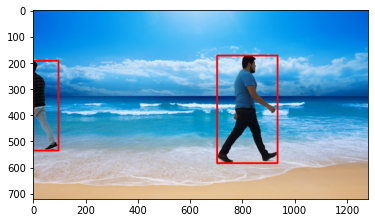

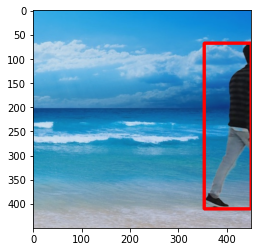

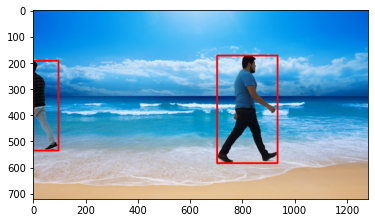

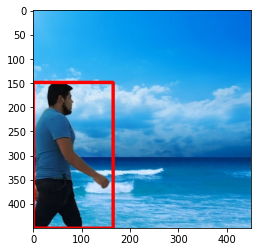

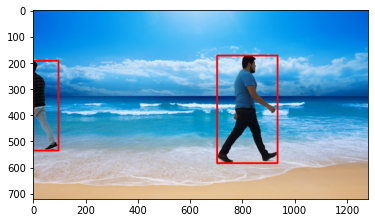

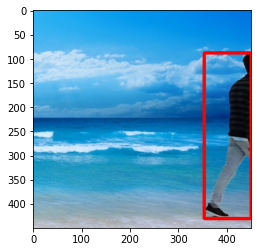

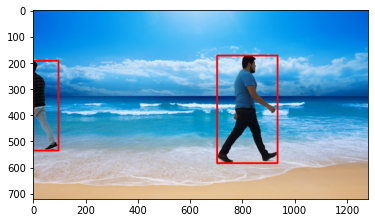

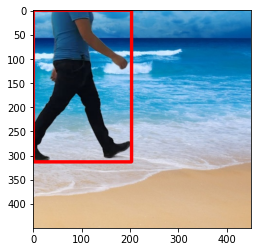

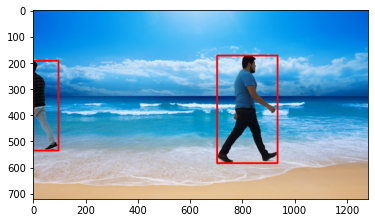

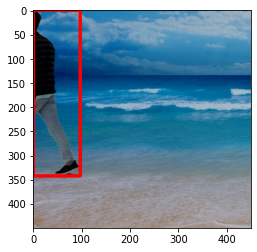

In [82]:
dir_path = "/home/josmar/proyectos/codes/datasets/ucb_gait_combined/images"
n = 5
for i in range(n):
    # rand_id =random.choice(imgIds)
    image, class_labels, bboxes, masks = get_img_info(coco = coco, imgId = rand_id)
    t_image, t_labels, t_bboxes, t_masks = transform_image(transform, image, class_labels, bboxes, masks)
    show_bbox_coco(image, bboxes)
    show_bbox_coco(t_image,t_bboxes)
    


In [496]:
print(bboxes[0])
print(ratio_fg(image, [bboxes[0]]))
#0.0001
#0.0003

[1271.0, 486.0, 9.0, 35.0]
0.000341796875


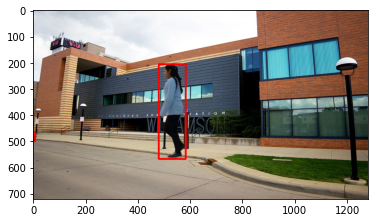

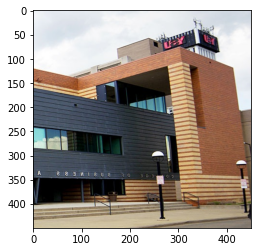

In [492]:
show_bbox_coco(image,bboxes)
show_bbox_coco(t_image,t_bboxes)

The cell below takes 4.44 ms ± 52.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

In [461]:
def ratio_fg(image, bboxes):
    max_area = image.shape[0] * image.shape[1]
    area = 0
    for bbox in bboxes:
        area += bbox[2]*bbox[3]
    return (area/max_area)

The cell below takes 5.9 ms ± 16.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

In [455]:

img_license = 0
img_id=0
ann_id=0
is_crowd=0
img_cat = 1
images=[]
annotations = []

for submask in t_masks:
    annotation = mask_to_annotation(submask , img_id, img_cat, ann_id, is_crowd)
    annotations.append(annotation)
    ann_id+=1

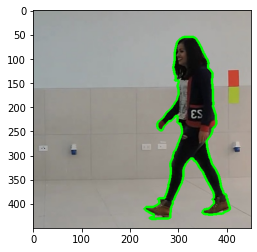

In [456]:
polys = []
for ann in annotations:
    poly_img = ann["segmentation"]
    for poly in poly_img:
        poly = np.reshape(poly, (-1,2))
        polys.append(np.int32(poly)) 
show_polygon(t_image,polys)